# Предсказание данных **x + шум**

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path 

try:
    parent_dir = Path(__file__).resolve().parent.parent
except NameError:
    parent_dir = Path.cwd().parent
    
sys.path.append(str(parent_dir))
from MLP import NeuralNetwork, mse

### Подготовка данных

In [66]:
X = np.random.rand(1000, 1) * 10
y = X + np.random.normal(0, 1, X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Поиск лучшей архитектуры

In [67]:
input_layer_size = X_train.shape[1]
learning_rates = [0.1, 0.01, 0.001, 0.0001]

architectures = {
    '1x32x1': [input_layer_size, 32, 1],
    '1x64x1': [input_layer_size, 64, 1],
    '1x64x32x1': [input_layer_size, 64, 32, 1],
    '1x64x64x1': [input_layer_size, 64, 64, 1]  
}

results = {}

for name, layer_sizes in architectures.items():
    for lr in learning_rates:
        print(f"\nОбучение: {name}")
        model = NeuralNetwork(layer_sizes, activation='relu', task='regression')
        losses = model.train(X_train_scaled, y_train, epochs=500, batch_size=32, learning_rate=lr)
        y_pred = model.predict(X_test_scaled)
        loss = mse(y_test, y_pred)
        
        key = f"{name}_{lr}"
        results[key] = {
            'loss': loss,
            'losses': losses,
            'architecture': layer_sizes,
            'learning_rate': lr,
            'parameters': model.parameters 
        }
        print(f"Test MSE: {loss:.5f}")


Обучение: 1x32x1
Epoch 100/500, Loss: 0.9065
Epoch 200/500, Loss: 0.9031
Epoch 300/500, Loss: 0.9974
Epoch 400/500, Loss: 0.9115
Epoch 500/500, Loss: 0.9088
Test MSE: 0.93150

Обучение: 1x32x1
Epoch 100/500, Loss: 0.9032
Epoch 200/500, Loss: 0.9031
Epoch 300/500, Loss: 0.9024
Epoch 400/500, Loss: 0.9024
Epoch 500/500, Loss: 0.9045
Test MSE: 0.94977

Обучение: 1x32x1
Epoch 100/500, Loss: 0.9295
Epoch 200/500, Loss: 0.9154
Epoch 300/500, Loss: 0.9119
Epoch 400/500, Loss: 0.9098
Epoch 500/500, Loss: 0.9084
Test MSE: 0.93294

Обучение: 1x32x1
Epoch 100/500, Loss: 7.0357
Epoch 200/500, Loss: 1.1564
Epoch 300/500, Loss: 1.0083
Epoch 400/500, Loss: 0.9811
Epoch 500/500, Loss: 0.9636
Test MSE: 0.99500

Обучение: 1x64x1
Epoch 100/500, Loss: 0.9276
Epoch 200/500, Loss: 0.9104
Epoch 300/500, Loss: 0.9001
Epoch 400/500, Loss: 0.9009
Epoch 500/500, Loss: 0.9235
Test MSE: 0.98039

Обучение: 1x64x1
Epoch 100/500, Loss: 0.9056
Epoch 200/500, Loss: 0.9032
Epoch 300/500, Loss: 0.9024
Epoch 400/500, Los

### Вывод результатов

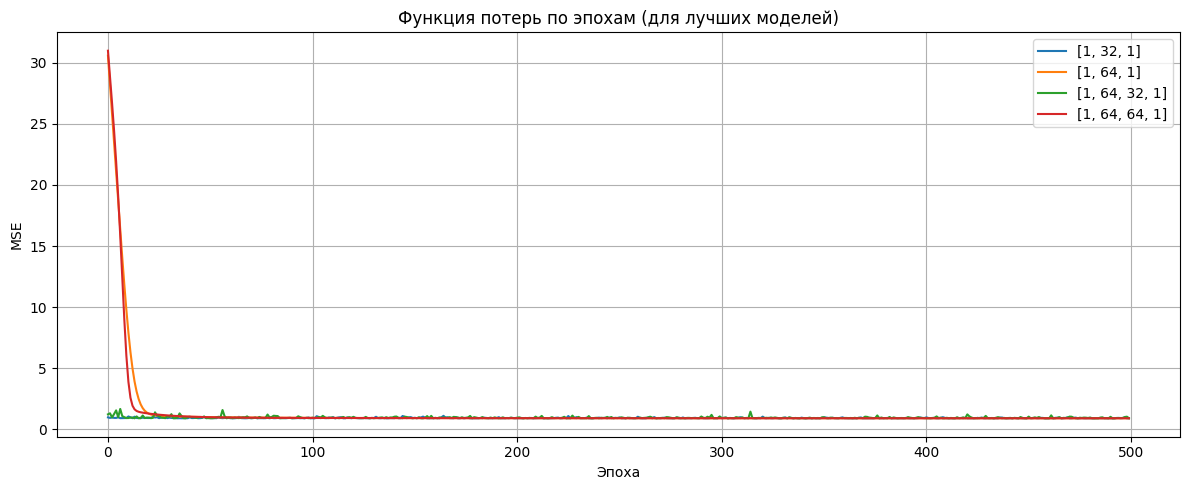

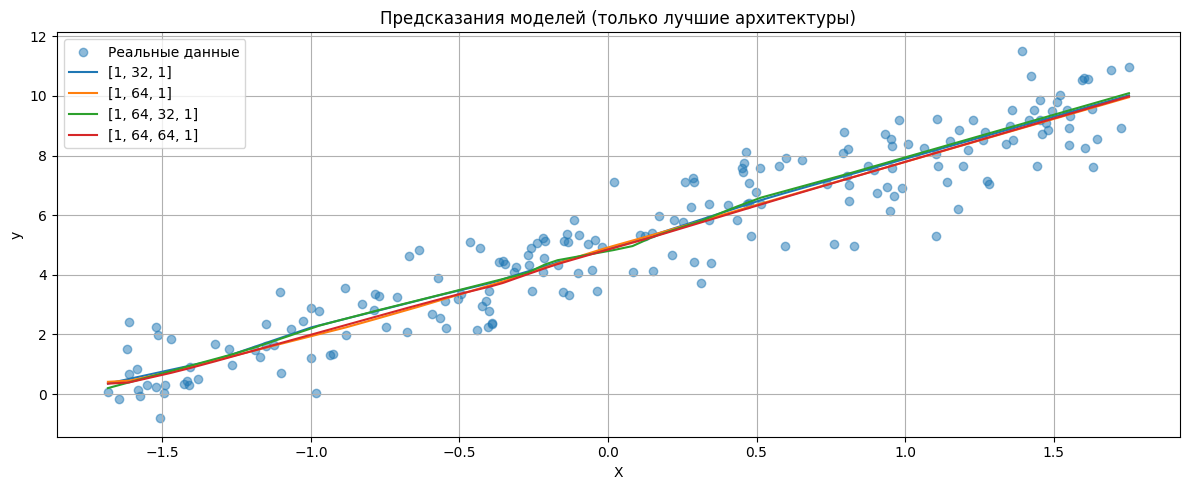

In [68]:
best_by_arch = {}

for key, val in results.items():
    arch = str(val['architecture']) 
    current_loss = val['loss']
    
    if arch not in best_by_arch or current_loss < best_by_arch[arch]['loss']:
        best_by_arch[arch] = val

plt.figure(figsize=(12, 5))
for arch_str, res in best_by_arch.items():
    plt.plot(res['losses'], label=arch_str)

plt.title("Функция потерь по эпохам (для лучших моделей)")
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sorted_idx = np.argsort(X_test_scaled[:, 0])
X_test_sorted = X_test_scaled[sorted_idx]
y_test_sorted = y_test[sorted_idx]

plt.figure(figsize=(12, 5))
plt.scatter(X_test_sorted, y_test_sorted, alpha=0.5, label="Реальные данные")

for arch_str, res in best_by_arch.items():
    temp_model = NeuralNetwork(res['architecture'], activation='relu', task='regression')
    temp_model.parameters = res['parameters']
    
    y_pred = temp_model.predict(X_test_scaled)[sorted_idx]
    plt.plot(X_test_sorted, y_pred, label=f"{arch_str}")

plt.title("Предсказания моделей (только лучшие архитектуры)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Обучение и предсказание

In [69]:
best_model_name = min(results, key=lambda k: results[k]['loss'])

best_architecture = results[best_model_name]['architecture']
best_learning_rate = results[best_model_name]['learning_rate']
print(f"Best architecture: {best_architecture}, learning rate: {best_learning_rate}") # (best_architecture, best_learning_rate)

model = NeuralNetwork(best_architecture, 
                      activation='relu',
                      task='regression')
loses = model.train(X_train_scaled, y_train, 
                    epochs=500, 
                    batch_size=32, 
                    learning_rate=best_learning_rate)

y_pred = model.predict(X_test_scaled)

Best architecture: [1, 32, 1], learning rate: 0.1
Epoch 100/500, Loss: 0.9197
Epoch 200/500, Loss: 0.9016
Epoch 300/500, Loss: 0.9892
Epoch 400/500, Loss: 0.9334
Epoch 500/500, Loss: 0.9112


### Визуализация

Test MSE: 0.9645


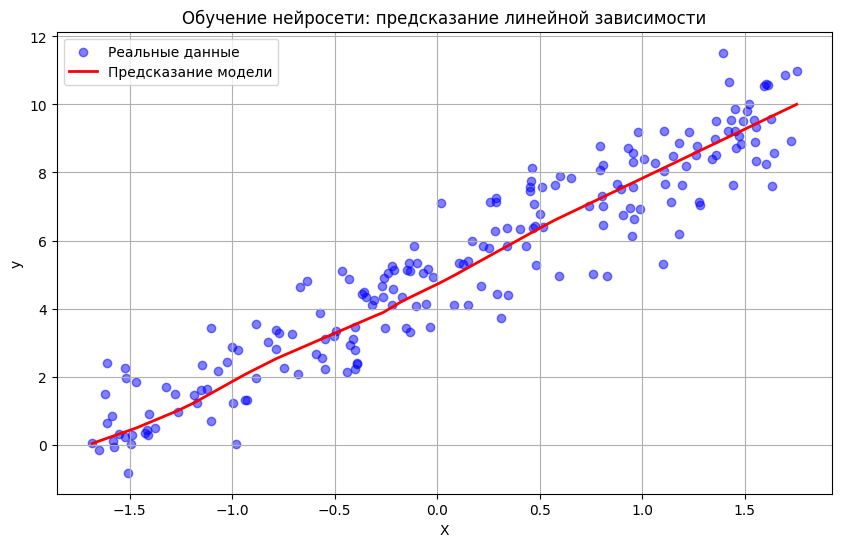

In [70]:
test_loss = mse(y_test, y_pred)
print(f"Test MSE: {test_loss:.4f}")

sorted_indices = np.argsort(X_test_scaled[:, 0])

plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[sorted_indices], y_test[sorted_indices], color='blue', alpha=0.5, label='Реальные данные')
plt.plot(X_test_scaled[sorted_indices], y_pred[sorted_indices], color='red', linewidth=2, label='Предсказание модели')
plt.title('Обучение нейросети: предсказание линейной зависимости')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()